In [23]:
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score
import statsmodels.stats.outliers_influence as inf
from statsmodels.multivariate.manova import MANOVA
import statsmodels.api as sm
import scipy.stats as stats
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
from imblearn.over_sampling import SMOTE
import seaborn as sns

In [24]:
import matplotlib.pyplot as plt
import math
import os
from astropy.io import fits, ascii
from astropy.table import Table, hstack, join
from astropy.stats import binom_conf_interval


In gal_fnal_dr7_v5_2.fits.gz, there is a column named CMODEL which is actually a length‐5 array of SDSS “CModel” magnitudes in the order 
[u,g,r,i,z]

In [25]:
t0 = Table.read('data/gal_fnal_dr7_v5_2.fit.gz')

In [26]:
plate =t0["PLATE"]
mjd   = t0["MJD"]
fiber = t0["FIBERID"]
cmodel= t0["CMODEL"]
u_mag = cmodel[:, 0]
g_mag = cmodel[:, 1]
r_mag = cmodel[:, 2]
i_mag = cmodel[:, 3]
z_mag = cmodel[:, 4]
phot = Table([plate,mjd, fiber, u_mag, g_mag, r_mag, i_mag, z_mag], 
             names=("PLATEID","MJD", "FIBERID", "u_mag", "g_mag", "r_mag", "i_mag", "z_mag"))


In [27]:
tr = ascii.read('Table1.dat')
column_mapping = {'col1': 'PLATEID', 'col2': 'MJD', 'col3': 'FIBERID','col4' :'ra' ,'col5': 'dec','col6' : 'redshift','col7' : 'SNVSS','col8':'RCl','col9':'SFIRST' ,'col11':'RLAGN','col12': 'main-sample','col13':'LERG','col14':'HERG'}
for old_name, new_name in column_mapping.items():
    tr.rename_column(old_name, new_name)
mask = tr['RLAGN'] == 1
bh201 = tr[mask]
bh2012 = bh201[["PLATEID","MJD", "FIBERID",'LERG','HERG']] # table lenght = 15300 all are RLAGN 
bh_clean = bh2012[(bh2012['LERG'] == 1) | (bh2012['HERG'] == 1)] # LERG = 9863, herg = 481,  9863 + 481 = 10344 are all agn with defined labels

In [28]:
t2 = Table.read('data/gal_info_dr7_v5_2.fit.gz')
info_df = t2[['PLATEID','MJD','FIBERID','Z']]

In [29]:
t3 = Table.read('data/totlgm_dr7_v5_2.fit.gz')
mass_df = t3[['AVG']]

In [30]:
t4 = Table.read('data/gal_totsfr_dr7_v5_2.fits.gz')
sfr_df = t4[['AVG']]

In [31]:
info_mass = hstack([info_df, mass_df])
column_map = {'AVG': 'stellar_mass'}
for old_name, new_name in column_map.items():
    info_mass.rename_column(old_name, new_name)
info_mass_sfr = hstack([info_mass, sfr_df])
column_map1 = {'AVG': 'sfr'}
for old_name, new_name in column_map1.items():
    info_mass_sfr.rename_column(old_name, new_name) #Table length=927552
mpa_jhu = join(info_mass_sfr, phot, keys=['PLATEID','MJD','FIBERID'], join_type='inner') #Table length=927552

In [32]:
df = join(mpa_jhu, bh_clean, keys=['PLATEID','MJD','FIBERID'], join_type='inner') # tab;e ;enght = 10344 (not 15300 )same as bestheck RLAGN sample with defined labels

 i have Table length=15300  
PLATEID	MJD	FIBERID	Z	stellar_mass	sfr	u_mag	g_mag	r_mag	i_mag	z_mag	LERG	HERG

### Computing “u − r” 

In [33]:
df["u-r"] = df["u_mag"] - df["r_mag"]
df['log_stellar_mass'] = df['stellar_mass']  # Already in log
df['log_stellar_mass'] = np.where(df['log_stellar_mass'] <= 0, np.nan, df['log_stellar_mass'])  # Mask bad values
df['log_sfr'] = df['sfr']
df['log_sfr'] = np.where(df['log_sfr'] <= -90, np.nan, df['log_sfr'])
df['label'] = np.where(df['LERG'] == 1, 0, 1) # If L == 1 → label = 0 (LERG) Else → label = 1 (HERG)
def assign_label(row):
    if row['LERG'] == 1:
        return 0
    elif row['HERG'] == 1:
        return 1
    else:
        return 2  # Ambiguous

In [34]:
df = df.to_pandas()

# Which host features drive HERG vs. LERG triggering clearly?

i.e., we start with random forest classifier using subset of best and heckman(2012) that is strictly RLAGN and is also strictly either LERG or HERG. by doing so we have made a simplistic binary classification model. 

I chose features based on prior studies (see Best & Heckman 2012), these host properties are expected to distinguish HERG and LERG hosts.

In [35]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.model_selection import GridSearchCV

### how we will build our model:

now we simply create two NumPy arrays:

X — your "features" (matrix of shape [n_samples, n_features])  
y — your target label (vector of 0s and 1s; 0 = LERG, 1 = HERG)

Then we do a Train/Validation/Test split using Stratified splitting in which the class ratio is preserved in each subset.

Next ...
we build the model : Random Forest Classifier [Builds an ensemble of decision trees (good for tabular data, robust to feature correlations)]

Validation and metrics: validationg the model and calculate metrics (accuracy, precision, recall, f1, ROC-AUC, etc.).

In [36]:
from sklearn.impute import SimpleImputer # Handles missing values (NaN) by filling with the median.
from sklearn.pipeline import Pipeline  # The Pipeline runs imputation and classification together—good for reproducibility and code clarity

feature_cols = ["log_stellar_mass", "log_sfr", "u-r"]  
X = df[feature_cols].values
y = df["label"].values

# Train/val/test split (stratified):
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.30, random_state=42, stratify=y
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, random_state=42, stratify=y_temp
)

# Define a pipeline with imputation and Random Forest
# by imputing we are filling missing data with meaningful statistical estimates (usually median or mean)
model_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),  # fills missing values
    ('rf', RandomForestClassifier(
        n_estimators=100, 
        random_state=42, 
        class_weight='balanced'
    ))
])

# Fit the model
model_pipeline.fit(X_train, y_train)

# Predict and evaluate on validation set
y_val_pred = model_pipeline.predict(X_val)
y_val_proba = model_pipeline.predict_proba(X_val)[:, 1]

print("Validation Classification Report:\n", classification_report(y_val, y_val_pred))
print("Validation ROC-AUC:", roc_auc_score(y_val, y_val_proba))


Validation Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.98      0.97      1480
           1       0.16      0.07      0.10        72

    accuracy                           0.94      1552
   macro avg       0.56      0.53      0.53      1552
weighted avg       0.92      0.94      0.93      1552

Validation ROC-AUC: 0.7126783033033033


| Metric     | LERG (0)           | HERG (1)             |
|------------|--------------------|----------------------|
| Precision  | 96% (good)         | 16% (very low)       |
| Recall     | 98% (excellent)    | 7% (extremely low)   |
| F1-score   | 97% (good)         | 10% (very poor)      |
|------------|--------------------|----------------------|
|ROC-AUC   |  0.712 (poor-fair, should be ≥ 0.75 ideally)| 

- classifier currently strongly favors the majority class (LERG) and struggles greatly with the minority class (HERG)
- the validation metrics indicate a significant class imbalance issue.
- because HERGs are heavily outnumbered by LERGs in the dataset, causing the classifier to bias predictions strongly toward the majority class.

# To address this imbalance and improve model performance

1. we can try to explicitly aadjust the class weight or (Already gives the best overall result)

I will include SMOTE and threshold-tuning results in an appendix or supplementary analysis.  

2. Try the SMOTE oversampling  
3. Lastly, we could try adjusting thresholds to fine-tune predictions

In [37]:
from sklearn.utils.class_weight import compute_class_weight

# Compute custom class weights explicitly:
class_weights = compute_class_weight('balanced', classes=[0, 1], y=y_train)
class_weight_dict = {0: class_weights[0], 1: class_weights[1]}
print("Class weights:", class_weight_dict)

# Re-run Random Forest explicitly:
model_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('rf', RandomForestClassifier(
        n_estimators=200, 
        random_state=42, 
        class_weight=class_weight_dict,
        max_depth=10
    ))
])

model_pipeline.fit(X_train, y_train)

# Check performance again:
y_val_pred = model_pipeline.predict(X_val)
y_val_proba = model_pipeline.predict_proba(X_val)[:, 1]

print(classification_report(y_val, y_val_pred))
print("Validation ROC-AUC:", roc_auc_score(y_val, y_val_proba))


Class weights: {0: 0.5244096769520499, 1: 10.741839762611276}
              precision    recall  f1-score   support

           0       0.97      0.86      0.91      1480
           1       0.12      0.39      0.19        72

    accuracy                           0.84      1552
   macro avg       0.54      0.63      0.55      1552
weighted avg       0.93      0.84      0.88      1552

Validation ROC-AUC: 0.7776933183183183


In [38]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)

# First impute missing values:
imputer = SimpleImputer(strategy='median')
X_train_imp = imputer.fit_transform(X_train)

# Oversample with SMOTE:
X_train_smote, y_train_smote = smote.fit_resample(X_train_imp, y_train)

# Fit Random Forest to oversampled data:
rf_smote = RandomForestClassifier(n_estimators=200, random_state=42)
rf_smote.fit(X_train_smote, y_train_smote)

# Evaluate:
X_val_imp = imputer.transform(X_val)
y_val_pred_smote = rf_smote.predict(X_val_imp)
y_val_proba_smote = rf_smote.predict_proba(X_val_imp)[:, 1]

print("After SMOTE:")
print(classification_report(y_val, y_val_pred_smote))
print("Validation ROC-AUC:", roc_auc_score(y_val, y_val_proba_smote))


After SMOTE:
              precision    recall  f1-score   support

           0       0.96      0.83      0.89      1480
           1       0.10      0.38      0.15        72

    accuracy                           0.81      1552
   macro avg       0.53      0.60      0.52      1552
weighted avg       0.92      0.81      0.86      1552

Validation ROC-AUC: 0.6873592342342343


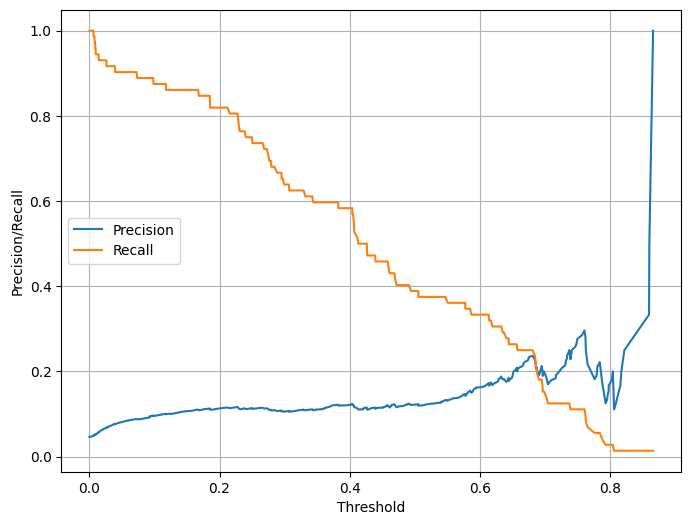

Results at threshold = 0.2:
              precision    recall  f1-score   support

           0       0.99      0.69      0.81      1480
           1       0.11      0.82      0.20        72

    accuracy                           0.69      1552
   macro avg       0.55      0.75      0.50      1552
weighted avg       0.95      0.69      0.78      1552

ROC-AUC: 0.7776933183183183


In [39]:
from sklearn.metrics import precision_recall_curve

precision, recall, thresholds = precision_recall_curve(y_val, y_val_proba)

# Plot precision-recall curve to pick optimal threshold:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
plt.plot(thresholds, precision[:-1], label='Precision')
plt.plot(thresholds, recall[:-1], label='Recall')
plt.xlabel('Threshold')
plt.ylabel('Precision/Recall')
plt.legend()
plt.grid()
plt.show()

# Try a lower threshold manually:
threshold = 0.2  # Example: pick threshold giving good balance
y_val_pred_adj = (y_val_proba >= threshold).astype(int)

print(f"Results at threshold = {threshold}:")
print(classification_report(y_val, y_val_pred_adj))
print("ROC-AUC:", roc_auc_score(y_val, y_val_proba))


| Approach            | HERG Precision | HERG Recall | HERG F1 | ROC-AUC |
| ------------------- | -------------- | ----------- | ------- | ------- |
| **Class weight**    | 0.12           | 0.39        | 0.19    | 0.77    |
| **SMOTE**           | 0.10           | 0.38        | 0.15    | 0.68    |
| **Threshold (0.2)** | 0.11           | 0.82        | 0.20    | 0.77    |


Rf learned the following order of feauture imprtance: 

Stellar mass (sfr) is the most important predictor > followed by star formation rate (log_sfr) > then color (u-r)

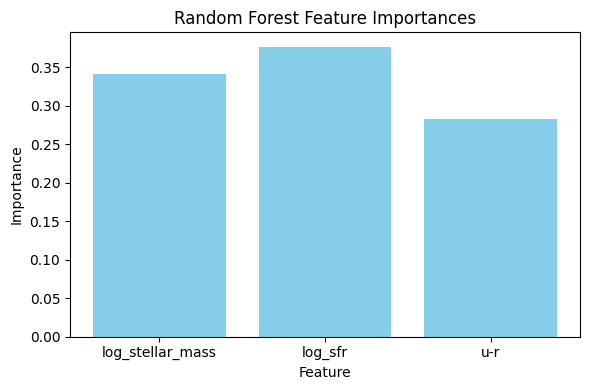

In [40]:
import matplotlib.pyplot as plt

rf_model = model_pipeline.named_steps['rf']  # Get RF from pipeline
importances = rf_model.feature_importances_

plt.figure(figsize=(6,4))
plt.bar(feature_cols, importances, color='skyblue')
plt.title("Random Forest Feature Importances")
plt.ylabel("Importance")
plt.xlabel("Feature")
plt.tight_layout()
plt.show()


# confusion Matrix

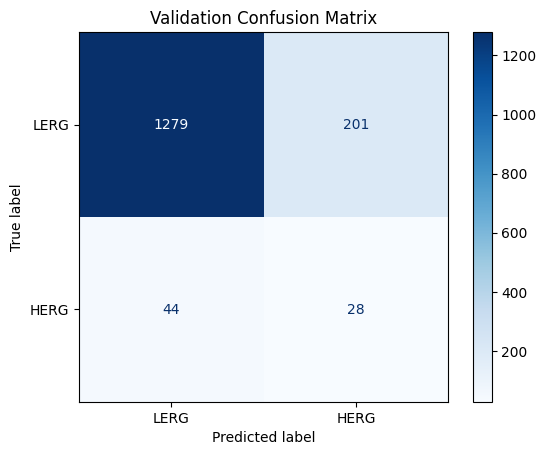

In [41]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_val, y_val_pred)  
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["LERG", "HERG"])
disp.plot(cmap="Blues")
plt.title("Validation Confusion Matrix")
plt.show()


Interpretation:

1279 true LERGs correctly classified (true negatives)

201 true LERGs misclassified as HERG (false positives)

44 true HERGs misclassified as LERG (false negatives)

28 true HERGs correctly classified (true positives)